In [1]:
%load_ext autoreload
%autoreload 2

import torch
import notebook_setup

device = torch.device('cpu')

/home/brendan/anaconda3/envs/impl/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data

Define data distribution and take a sample

In [2]:
import numpy as np
import torch
from callbacks import UpdateProgressBarStats
from implicit.datasets import TorusDistribution
from visualization import plot_3d_points
from numpyro.examples.datasets import NINE_MERS, load_dataset
import matplotlib.pyplot as plt

 
def fetch_aa_dihedrals(aa):
    _, fetch = load_dataset(NINE_MERS, split=aa)
    return np.stack(fetch())

angle_dataset = fetch_aa_dihedrals("G")
angle_dataset = torch.Tensor(angle_dataset.astype(float))


# Convert angles to torus
centre = (0., 0., 0.)
R = 3
r = 1

data = TorusDistribution.angles_to_euclidean(angle_dataset, R=R, r=r)

lims = {"xlims": (-4.1, 4.1), "ylims": (-4.1, 4.1), "zlims": (-2.7, 2.7)} # Set lims for each plot
ebm_lims = torch.Tensor((lims["xlims"], lims["ylims"], lims["zlims"])).T

dataloader = data.split(50)
callbacks = [UpdateProgressBarStats(loader=dataloader)]

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


<Figure size 1600x1000 with 0 Axes>

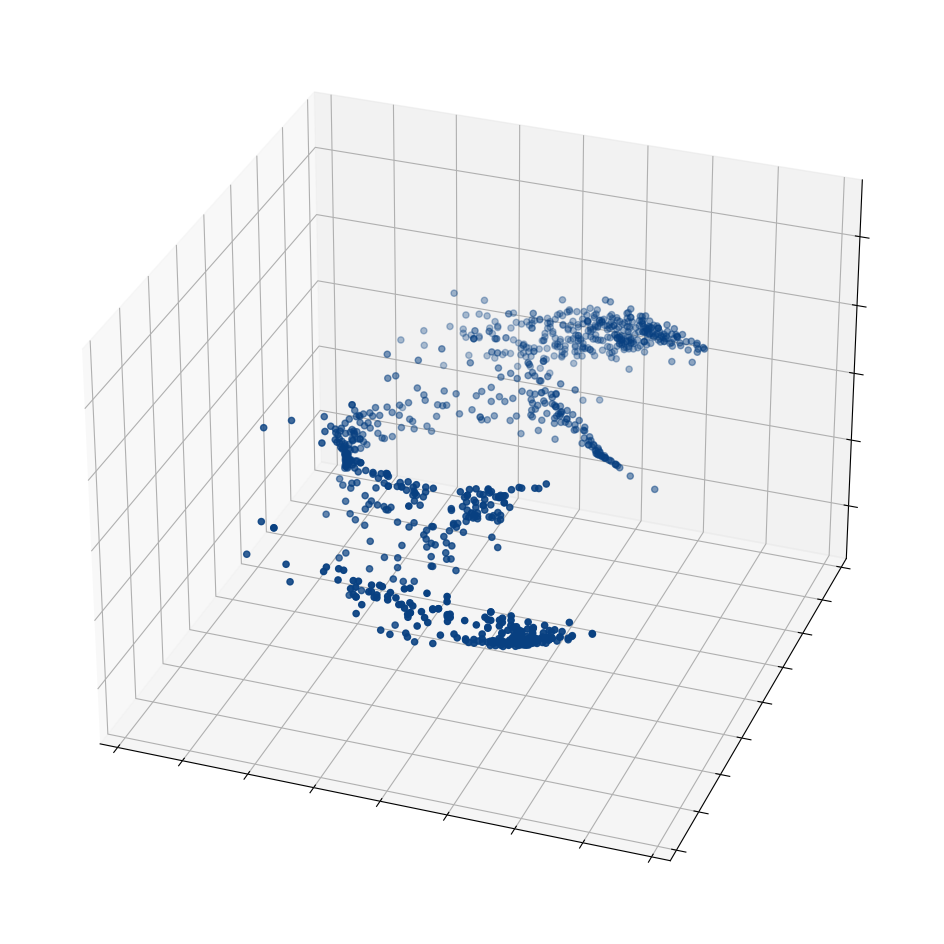

In [3]:
fig = plt.figure(figsize=(16, 10))
plot_3d_points(data, **lims, elev=30, azim=290)

## EBIM

Initialize and optimize a manifold-defining function (MDF).

In [4]:
%%time
from torch import optim
from implicit.maps import FlatSmoothMap
from implicit.models.ebm import ImplicitManifold

mdf = FlatSmoothMap(3, 1, num_layers=2, hidden_size=8)
manifold = ImplicitManifold(mdf, ebm_lims, device)
opt = optim.Adam(mdf.parameters(), lr=0.01)

manifold.train(
    optim=opt,
    dataloader=dataloader,
    epochs=100,
    mu=1.,
    sv_min=0.3,
    neg_weight=0.,
    callbacks=callbacks,
)

[E100] loss: 0.0046 | pos: 0.0042 | neg: 0.0000 | sv_min: 0.0004 | sv_max: 0.0000 | scale: 0.0000: 100%|████████████| 100/100 [00:09<00:00, 10.47it/s]


CPU times: user 9.71 s, sys: 862 ms, total: 10.6 s
Wall time: 9.56 s


In [5]:
from implicit.metrics import distance_to_implicit_manifold

implicit_dists = distance_to_implicit_manifold(data, manifold, opt_steps=100)
implicit_dists.min(), implicit_dists.median(), implicit_dists.mean(), implicit_dists.max()

(tensor(3.5763e-07), tensor(0.0097), tensor(0.0126), tensor(0.1734))

Initialize and optimize a constrained EBM

In [6]:
%%time
from implicit.models.ebm import ConstrainedEBM

energy = FlatSmoothMap(3, 1, spectral_norm=False)
cebm = ConstrainedEBM(manifold, energy, lims=ebm_lims, device=device, buffer_size=1000)

opt = optim.Adam(energy.parameters(), lr=0.01)

cebm.train(
    optim=opt,
    dataloader=dataloader, 
    epochs=10,
    beta=0.3,
    clip_norm=1.,
    buffer_frac=0.95,
    noise_kwargs={
        "opt_steps": 1,
        "line_search_fn": "strong_wolfe",
    },
    mc_kwargs={
        "n_steps": 10,
        "eps": 0.1,
        "alpha": None,
        "grad_clamp": 0.03,
        "opt_steps": 1,
        "line_search_fn": "strong_wolfe"
    },
    callbacks=callbacks,
)

[E 10] loss: -0.9602 | scale_loss: 3.1980: 100%|██████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.23s/it]

CPU times: user 1min 18s, sys: 401 ms, total: 1min 19s
Wall time: 1min 12s


In [7]:
import matplotlib.colors as colors
from matplotlib import cm

cmap_gnbu = cm.GnBu # default colormap
# darkened colormap
cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap_gnbu.name, a=0.2, b=1.0),
        cmap_gnbu(np.linspace(0.2, 1.0, 100)))

<Figure size 1600x1000 with 0 Axes>

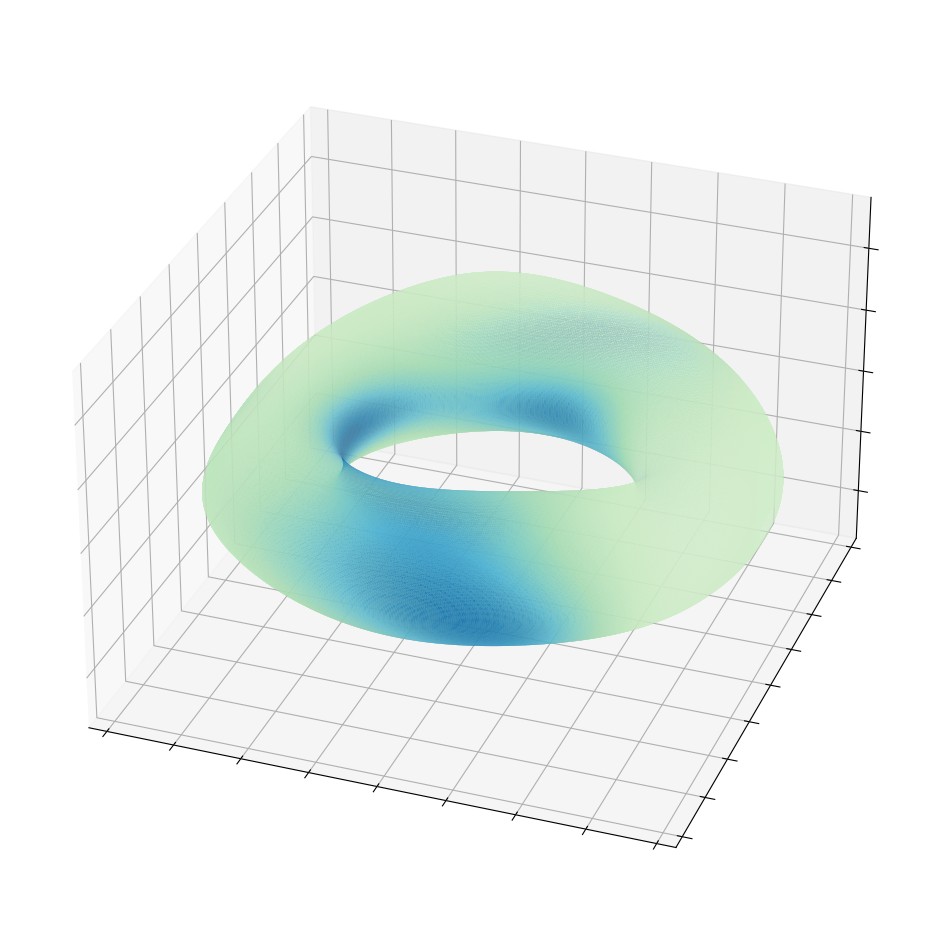

In [8]:
from visualization import plot_mdf_surface

# Partition not necessary as density gets normalized by plot_trisurf
#uniform_points = TorusDistribution.uniform_torus_sample(count=1000, R=R, r=r, centre=centre)
#mc_partition = torch.exp(-energy(uniform_points)/4).squeeze().mean() * 4 * np.pi**2 * R * r

density_func = lambda x: torch.exp(-energy(x)/3).squeeze() # Increase temperature for visibility

fig = plt.figure(figsize=(16, 10))
plot_mdf_surface(mdf, density_func, res=300, **lims, equal_aspect=True, cmap=cmap, elev=30, azim=290)

In [9]:
from implicit.metrics import wasserstein_discretized_density_to_points

learned_points = cebm.sample_noise(10000, batch_size=3000, line_search_fn="strong_wolfe")
with torch.no_grad():
    learned_densities = density_func(learned_points)
gt_points = data

wasserstein_discretized_density_to_points(
    learned_points,
    learned_densities,
    gt_points,
    ebm_lims.T.numpy(),
    granularity=30,
)

0.026094099790782702

# Pushforward EBM

Initialize and train an autoencoder with latent EBM

In [10]:
%%time
from itertools import chain
from implicit.models.ebm import PushforwardEBM
from implicit.models.autoencoder import Autoencoder

encoder = FlatSmoothMap(3, 2, num_layers=3)
decoder = FlatSmoothMap(2, 3, num_layers=3)
latent_energy = FlatSmoothMap(2, 1)

ae = Autoencoder(encoder, decoder, device=device)
ae_ebm = PushforwardEBM(ae, latent_energy, device=device, buffer_size=1000)

ae_ebm.train_ae(
    optim=optim.Adam(chain(encoder.parameters(), decoder.parameters()), lr=0.001),
    dataloader=dataloader, 
    epochs=500,
    clip_norm=1.,
    callbacks=callbacks,
)

[E500] loss: 0.0010: 100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:59<00:00,  8.43it/s]


CPU times: user 58.1 s, sys: 5.26 s, total: 1min 3s
Wall time: 59.3 s


In [11]:
from implicit.metrics import distance_to_pushforward_manifold

ae_dists = distance_to_pushforward_manifold(data, ae_ebm.autoencoder, opt_steps=100)
ae_dists.min(), ae_dists.median(), ae_dists.mean(), ae_dists.max()

(tensor(5.9065e-05), tensor(0.0127), tensor(0.0185), tensor(0.2696))

In [12]:
%%time

ae_ebm.train_ebm(
    optim=optim.Adam(latent_energy.parameters(), lr=0.01),
    dataloader=dataloader, 
    epochs=50, 
    beta=0.1,
    clip_norm=1.,
    buffer_frac=0.95,  
    mc_kwargs={
        "n_steps": 60,
        "eps": 0.5,
        "alpha": 10,
    },
    callbacks=callbacks,
)

[E 50] loss: -1.6377 | scale_loss: 14.3578: 100%|█████████████████████████████████████████████████████████████████████| 50/50 [02:00<00:00,  2.40s/it]

CPU times: user 1min 58s, sys: 1.97 s, total: 2min
Wall time: 2min


Plot learned density

<Figure size 1200x1200 with 0 Axes>

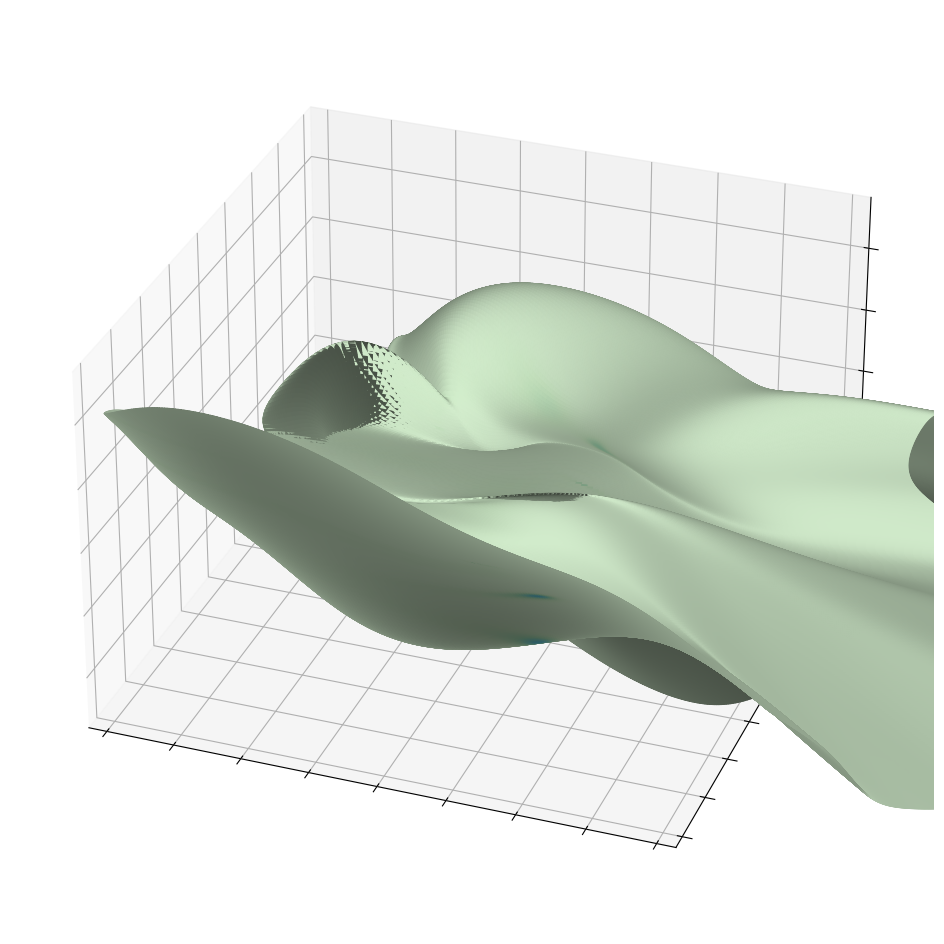

In [13]:
from visualization import plot_surface
import matplotlib.colors as mcolors

with torch.no_grad():
    lower, upper = ae_ebm.ebm.lims
    x = torch.linspace(lower[0].tolist(), upper[0].tolist(), 500)
    y = torch.linspace(lower[1].tolist(), upper[1].tolist(), 500)

    latent_grid = torch.stack(torch.meshgrid((x, y), indexing="xy"), dim=-1)
    ambient_grid = decoder(latent_grid)
    densities = ae_ebm.prob(ambient_grid.reshape(-1, 3))
    densities = densities.reshape(*latent_grid.shape[:-1])

fig = plt.figure(figsize=(12, 12))
plot_surface(ambient_grid, facecolors=densities, cmap=cmap, **lims, equal_aspect=True, elev=30, azim=290, 
             lightsource=mcolors.LightSource(azdeg=320, altdeg=-20))

In [14]:
from visualization import plot_surface
import matplotlib.colors as mcolors

with torch.no_grad():
    lower, upper = ae_ebm.ebm.lims
    x = torch.linspace(lower[0].tolist(), upper[0].tolist(), 100)
    y = torch.linspace(lower[1].tolist(), upper[1].tolist(), 100)

    latent_points = torch.stack(torch.meshgrid((x, y), indexing="xy"), dim=-1).reshape(-1, 2)
    ae_ebm_points = decoder(latent_points)
    
    ae_ebm_densities = ae_ebm.prob(ae_ebm_points)
    
wasserstein_discretized_density_to_points(
    ae_ebm_points,
    ae_ebm_densities,
    gt_points,
    ebm_lims.T.numpy(),
    granularity=30,
)

0.03160475038362565